# midnite - Visualization Tutorial 1 - Part 1

in this notebook you will learn the intuition behind the features of the interpretability framework and how to us them.

## Gradient Class Activation Mapping (Grad-CAM) with ResNet

Demonstration of visualizing the class activation mapping for an image classification example with ResNet.


In [1]:
%matplotlib inline  
%load_ext autoreload
%autoreload 2  
%cd ../src

import data_utils
from data_utils import DataConfig
from model_utils import Flatten
import plot_utils
from PIL import Image

from midnite import get_device
from midnite.visualization import SaliencyMap
from midnite.visualization import GuidedBackpropagation
from midnite.visualization import SpatialSplit
from midnite.visualization import ChannelSplit
from midnite.visualization import NeuronSplit
from midnite.visualization import NeuronSelector

import torch
from torch import Tensor
from torch.nn import Softmax
from torch.nn.functional import interpolate

from torchvision import models

/home/christina/Development/interpretability-framework/src


## Step 1: Load pretrained model

In our example we use a pretrained ResNet for demonstration.

In [2]:
model = models.resnet50(pretrained=True)

model.eval()
model.to(get_device());

## Step 2: Load Image

In [3]:
img_path = "../data/imagenet_example_283.jpg"

# load image as torch tensor for computation, we can also load alexnet data for ResNet.
input_ = data_utils.get_example_from_path(img_path, DataConfig.ALEX_NET)

# load image as PIL Image for plotting and resizing
img = Image.open(img_path)
H, W = img.size

## Step 3: Select layer of interest

in ResNet, we have 9 layers, where 8 is the last feature layer and 10 the classification layer
Input: a list of layers which should be visualized as attribution.
**Note: choose layers between 1 and 8 for ResNet**

### Visualization of layer attributions
it is possible to visualize attributions of a single layer, or from several layers together. In this example we demonstrate both.

In [4]:
# example ResNet selection
selected_layer = 8

### Gradient-based Class Activation Mapping
<img src="resources/class-activation-mapping.png">

## Step 4: Select layer splits - Class Visualization example
in this example we want to analyze the top classes of the classification output. 
This means, we create a top-layer-selector with a Neuronsplit with the class of choice as split element.
Class 283 is the max classification for the imagenet_example_283. 

Additionally, it is possible to create a bottom_layer_selector to visualize the class activations in greater detail, e.g. channel-wise or neuron-wise.

### Possible splits for the NeuronSelector
<img src="resources/splits.png">
source: https://distill.pub/2018/building-blocks/

In [5]:
top_layer_selector = NeuronSelector(NeuronSplit(), [283])
bottom_layer_split = SpatialSplit()

## Step 5: Split the model into base_layers and inspection_layers
splitting the model with classification returns a list of base layers up to the selected single layer and the list of layers (inspection layers) from the selected layer until the last layer of the model, the classification layer. The output of the inspected layers is a classification with dimension (1, 1000)

In [6]:
base_layers = list(model.children())[:selected_layer]

inspection_layers = (
    list(model.children())[selected_layer:-1]
    + [Flatten()]
    + list(model.children())[-1:]
)

## Step 6: Generate Saliency Map

**Return values for each split:** 

* NeuronSplit() returns saliency with full dimensions of the selected layer - 3 dimensions (c, h, w)
* ChannelSplit() returns a saliency value for each channel, hence returns 1 dimension (c)
* SpatialSplit() returns a saliency value for each spatial, hence returns 2 dimensions (h, w)

### Example 1: Compute saliency map with bottom-layer spatial split

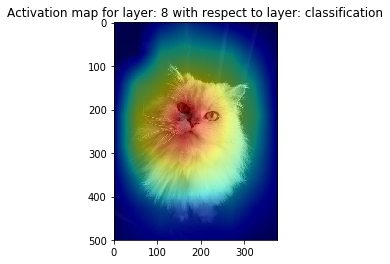

In [7]:
saliency = SaliencyMap(
    inspection_layers, 
    top_layer_selector, 
    base_layers, 
    bottom_layer_split
).visualize(input_)

# upsample saliency to the pixel dimensions of the image
sal_map = interpolate(
    saliency.unsqueeze(dim=0).unsqueeze(dim=0), 
    size=(H, W), 
    mode='bilinear', 
    align_corners=True
)

# plot saliencies with the input image
plot_utils.plot_saliency(sal_map, img, selected_layer, output_layer="classification")

## Guided Backpropagation

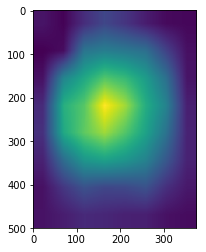

In [8]:
backprop = GuidedBackpropagation(
    (list(model.children())[:-1] + [Flatten()] + list(model.children())[-1:]),
    top_layer_selector,
    bottom_layer_split
).visualize(input_)

# plot saliencies with the input image
plot_utils.plot_guided_backprop(saliency, img)

### Example 2: Compute saliency map with bottom layer channel split.

In [9]:
top_layer_selector = NeuronSelector(NeuronSplit(), [283])
bottom_layer_split = ChannelSplit()

In [10]:
saliency = SaliencyMap(
    inspection_layers, 
    top_layer_selector, 
    base_layers, 
    bottom_layer_split
).visualize(input_)

top_values, top_channels = torch.topk(saliency, 5)

for (value, idx) in zip(top_values, top_channels):
    print("Channel number: {} with channel value: {}".format(idx, value))

Channel number: 243 with channel value: 6.798861704737647e-07
Channel number: 945 with channel value: 6.00816463247611e-07
Channel number: 1776 with channel value: 5.92619016970275e-07
Channel number: 39 with channel value: 4.82867335449555e-07
Channel number: 346 with channel value: 4.3539242255974386e-07


### Example 3: Compute saliency map with neuron split


In [11]:
bottom_layer_split = NeuronSplit()

Neuron activations for channel 39 of layer 8:


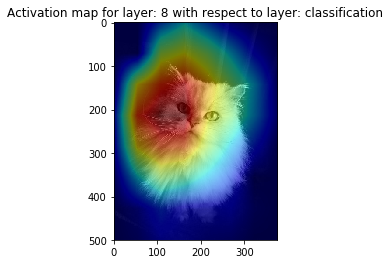

In [12]:
saliency = SaliencyMap(
    inspection_layers, 
    top_layer_selector, 
    base_layers, 
    bottom_layer_split
).visualize(input_)

print("Neuron activations for channel 39 of layer {}:".format(selected_layer))

# visualize the neurons of channel 39
# upsample saliency to the pixel dimensions of the image
sal_map = interpolate(
    saliency[39].unsqueeze(dim=0).unsqueeze(dim=0),
    size=(H, W),
    mode='bilinear', 
    align_corners=True
)

# plot saliencies neuron activations
plot_utils.plot_saliency(sal_map, img, selected_layer, output_layer="classification")